Ce challenge va vous permettre de tester les méthodes vues dans les différentes séquences de PRAMA, sur un jeu de données réel. Il s'agit ici d'une problématique de régression : la prévision du prix de vente des biens immobiliers situés dans le comté de King dans l'état de Washington. Ce comté contient notamment la ville de Seattle. Toutes les ventes immobilières ont eu lieu entre février 2014 et mai 2015.

Le dataset d'apprentissage contient 17 149 ventes immobilières, et celui de test en contient 4287. Vous n'avez pas accès au prix de vente des biens immobiliers du jeu test, qu'il vous faudra prédire. L'objectif de ce challenge est donc d'estimer des modèles à partir du jeu d'apprentissage puis de prévoir le prix des biens du jeu test. Vous avez un exemple de fichier à soumettre sur la plateforme kaggle ; il doit contenir deux colonnes : l'ID de la vente ainsi que le prix.

Le dataset contient 21 variables qui sont les suivantes :

id : Identifiant de la vente,

date : Date de la vente,

prix : Prix de vente,

nb_chambres : Nombre de chambres,

nb_sdb : Nombre de salles de bain, les valeurs 0.5 correspondent aux WC sans douche/baignoire,

m2_interieur : Surface en m2 de l'espace vivable de la maison,

m2_jardin : Surface en m2 de l'espace extérieur,

m2_etage : Surface en m2 des pièces situées au dessus du niveau du sol,

m2_soussol : Surface en m2 des pièces situées en dessous du niveau du sol,

nb_etages : Nombre d'étages,

vue_mer : Variable booléenne indiquant s'il y a une vue sur mer ou non,

vue_note : Note entre 0 et 4 indiquant la qualité de la vue,

etat_note : Note de 1 à 5 indiquant l'état de la maison,

design_note : Note de 1 à 13 indiquant le niveau de design de la maison,

annee_construction : Année de construction,

annee_renovation : Dernière année de rénovation s'il y a eu, sinon 0,

m2_interieur_15voisins : Surface en m2 de l'espace vivable des 15 voisins les plus proches,

m2_jardin_15voisins : Surface en m2 de l'espace extérieur des 15 voisins les plus proches,

zipcode : Zipcode de l'adresse de la maison

lat : latitude,

long : longitude

# Import

In [1]:
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import ensemble
import statsmodels.api as sm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

# Donées

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Define file paths
folder_path = "/content/drive/My Drive/PRAMA/"
train_path = folder_path + "train_data.csv"
test_path = folder_path + "test_data.csv"
submission_path = folder_path + "submission_sample.csv"

# Load datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
submission_df = pd.read_csv(submission_path)


# Display first few rows of train dataset
train_df.head()

Mounted at /content/drive


id                  date    prix  nb_chambres  nb_sdb  \
0  4443800785  2014-11-21T00:00:00Z  481000            2    1.00   
1  2722059013  2015-02-04T00:00:00Z  550000            2    1.00   
2  8856004730  2014-09-17T00:00:00Z  199950            2    2.75   
3  2473003210  2015-03-13T00:00:00Z  364808            3    1.75   
4  6743700335  2014-06-04T00:00:00Z  470000            3    2.00   

   m2_interieur    m2_jardin    m2_etage  m2_soussol  nb_etages  ...  \
0    150.501672   360.460795   85.470085   65.031587        1.0  ...   
1    117.985879  4046.822742  117.985879    0.000000        1.0  ...   
2    147.714604  1943.236715  147.714604    0.000000        1.5  ...   
3    215.533259   731.605351  150.501672   65.031587        1.0  ...   
4    167.224080  1176.978818  167.224080    0.000000        1.0  ...   

   vue_note  etat_note  design_note  annee_construction  annee_renovation  \
0         0          4            7                1924                 0   
1         0          4            5                1908                 0   
2         0          3            5                1920                 0   
3         0          3            8                1967                 0   
4         0          3            7                1956              1990   

   m2_interieur_15voisins  m2_jardin_15voisins  zipcode      lat     long  
0              123.560015           360.460795    98117  47.6855 -122.391  
1              173.727239           646.599777    98042  47.3651 -122.165  
2              121.701970           557.413601    98001  47.2786 -122.250  
3              184.875511           903.010033    98058  47.4524 -122.146  
4              183.017466           908.119658    98033  47.6935 -122.173  

[5 rows x 21 columns]

In [3]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17147 entries, 0 to 17146
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      17147 non-null  int64  
 1   date                    17147 non-null  object 
 2   prix                    17147 non-null  int64  
 3   nb_chambres             17147 non-null  int64  
 4   nb_sdb                  17147 non-null  float64
 5   m2_interieur            17147 non-null  float64
 6   m2_jardin               17147 non-null  float64
 7   m2_etage                17147 non-null  float64
 8   m2_soussol              17147 non-null  float64
 9   nb_etages               17147 non-null  float64
 10  vue_mer                 17147 non-null  int64  
 11  vue_note                17147 non-null  int64  
 12  etat_note               17147 non-null  int64  
 13  design_note             17147 non-null  int64  
 14  annee_construction      17147 non-null

id          prix   nb_chambres        nb_sdb  m2_interieur  \
count  1.714700e+04  1.714700e+04  17147.000000  17147.000000  17147.000000   
mean   4.605475e+09  5.431939e+05      3.371669      2.123010    193.732114   
std    2.879726e+09  3.716087e+05      0.932029      0.772906     85.587837   
min    1.000102e+06  7.500000e+04      0.000000      0.000000     26.941657   
25%    2.126059e+09  3.230000e+05      3.000000      1.750000    132.850242   
50%    3.905120e+09  4.500000e+05      3.000000      2.250000    178.372352   
75%    7.339452e+09  6.460000e+05      4.000000      2.500000    236.900780   
max    9.900000e+09  7.062500e+06     33.000000      7.750000    932.738759   

           m2_jardin      m2_etage    m2_soussol     nb_etages       vue_mer  \
count   17147.000000  17147.000000  17147.000000  17147.000000  17147.000000   
mean     1411.998121    166.652667     27.079448      1.497638      0.008048   
std      3879.062125     77.312579     41.221029      0.542015      0.089352   
min        48.309179     26.941657      0.000000      1.000000      0.000000   
25%       468.227425    111.482720      0.000000      1.000000      0.000000   
50%       706.150130    145.856559      0.000000      1.500000      0.000000   
75%       992.985879    206.243032     52.025269      2.000000      0.000000   
max    153414.994426    823.114084    447.788926      3.500000      1.000000   

           vue_note     etat_note   design_note  annee_construction  \
count  17147.000000  17147.000000  17147.000000        17147.000000   
mean       0.235376      3.409343      7.668630         1971.154721   
std        0.767578      0.649535      1.181903           29.378196   
min        0.000000      1.000000      1.000000         1900.000000   
25%        0.000000      3.000000      7.000000         1951.500000   
50%        0.000000      3.000000      7.000000         1975.000000   
75%        0.000000      4.000000      8.000000         1997.000000   
max        4.000000      5.000000     13.000000         2015.000000   

       annee_renovation  m2_interieur_15voisins  m2_jardin_15voisins  \
count      17147.000000            17147.000000         17147.000000   
mean          86.124453              184.852674          1187.418834   
std          405.556968               64.023277          2504.936376   
min            0.000000               37.068004            61.222594   
25%            0.000000              138.424378           473.801561   
50%            0.000000              170.940171           707.822371   
75%            0.000000              219.249350           936.780007   
max         2015.000000              576.923077         80936.454849   

            zipcode           lat          long  
count  17147.000000  17147.000000  17147.000000  
mean   98077.654808     47.560131   -122.213735  
std       53.455894      0.138478      0.140614  
min    98001.000000     47.155900   -122.519000  
25%    98033.000000     47.472300   -122.328000  
50%    98065.000000     47.572000   -122.230000  
75%    98117.000000     47.678100   -122.124500  
max    98199.000000     47.777600   -121.315000

In [4]:
#I divided date into day, month and year so we can analyse them seperatly
#and I droped the date variable

# Create a new DataFrame to work with
train_df_new = train_df.copy()

# Convert 'date' column to datetime format
train_df_new["date"] = pd.to_datetime(train_df_new["date"])

# Extract year, month, and day
train_df_new["year"] = train_df_new["date"].dt.year
train_df_new["month"] = train_df_new["date"].dt.month
train_df_new["day"] = train_df_new["date"].dt.day

# Drop the original 'date' column
train_df_new.drop(columns=["date"], inplace=True)

# Treat zipcode as a categorical variable
train_df_new["zipcode"] = train_df_new["zipcode"].astype("category")


# Display the first few rows
train_df_new.head()

id    prix  nb_chambres  nb_sdb  m2_interieur    m2_jardin  \
0  4443800785  481000            2    1.00    150.501672   360.460795   
1  2722059013  550000            2    1.00    117.985879  4046.822742   
2  8856004730  199950            2    2.75    147.714604  1943.236715   
3  2473003210  364808            3    1.75    215.533259   731.605351   
4  6743700335  470000            3    2.00    167.224080  1176.978818   

     m2_etage  m2_soussol  nb_etages  vue_mer  ...  annee_construction  \
0   85.470085   65.031587        1.0        0  ...                1924   
1  117.985879    0.000000        1.0        0  ...                1908   
2  147.714604    0.000000        1.5        0  ...                1920   
3  150.501672   65.031587        1.0        0  ...                1967   
4  167.224080    0.000000        1.0        0  ...                1956   

   annee_renovation  m2_interieur_15voisins  m2_jardin_15voisins  zipcode  \
0                 0              123.560015           360.460795    98117   
1                 0              173.727239           646.599777    98042   
2                 0              121.701970           557.413601    98001   
3                 0              184.875511           903.010033    98058   
4              1990              183.017466           908.119658    98033   

       lat     long  year  month  day  
0  47.6855 -122.391  2014     11   21  
1  47.3651 -122.165  2015      2    4  
2  47.2786 -122.250  2014      9   17  
3  47.4524 -122.146  2015      3   13  
4  47.6935 -122.173  2014      6    4  

[5 rows x 23 columns]

In [5]:
# Categorical variables
qualitative_vars = ["vue_mer", "zipcode"]
X_qual = train_df_new[qualitative_vars]

# Quantitative variables
quantitative_vars = [
    "nb_chambres", "nb_sdb", "m2_interieur", "m2_jardin", "m2_etage", "m2_soussol",
    "nb_etages", "vue_note", "etat_note", "design_note", "annee_construction",
    "annee_renovation", "m2_interieur_15voisins", "m2_jardin_15voisins",
    "lat", "long", "year", "month", "day"]
X_quant = train_df_new[quantitative_vars]

# Target variable
y = train_df_new["prix"]


# Analyse descrptif

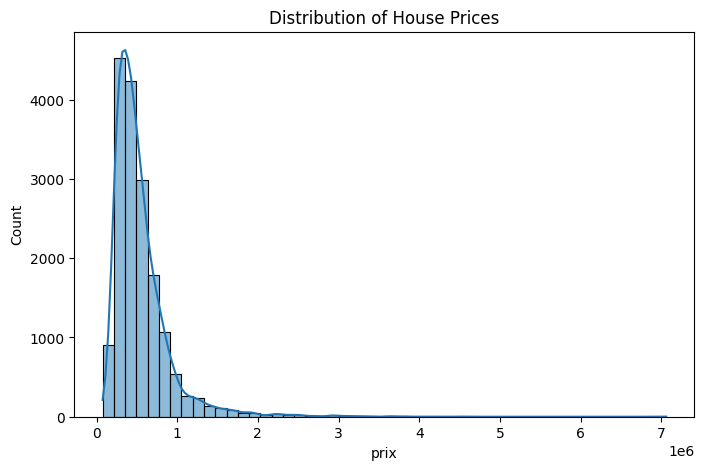

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(y, bins=50, kde=True)
plt.title("Distribution of House Prices")
plt.show()

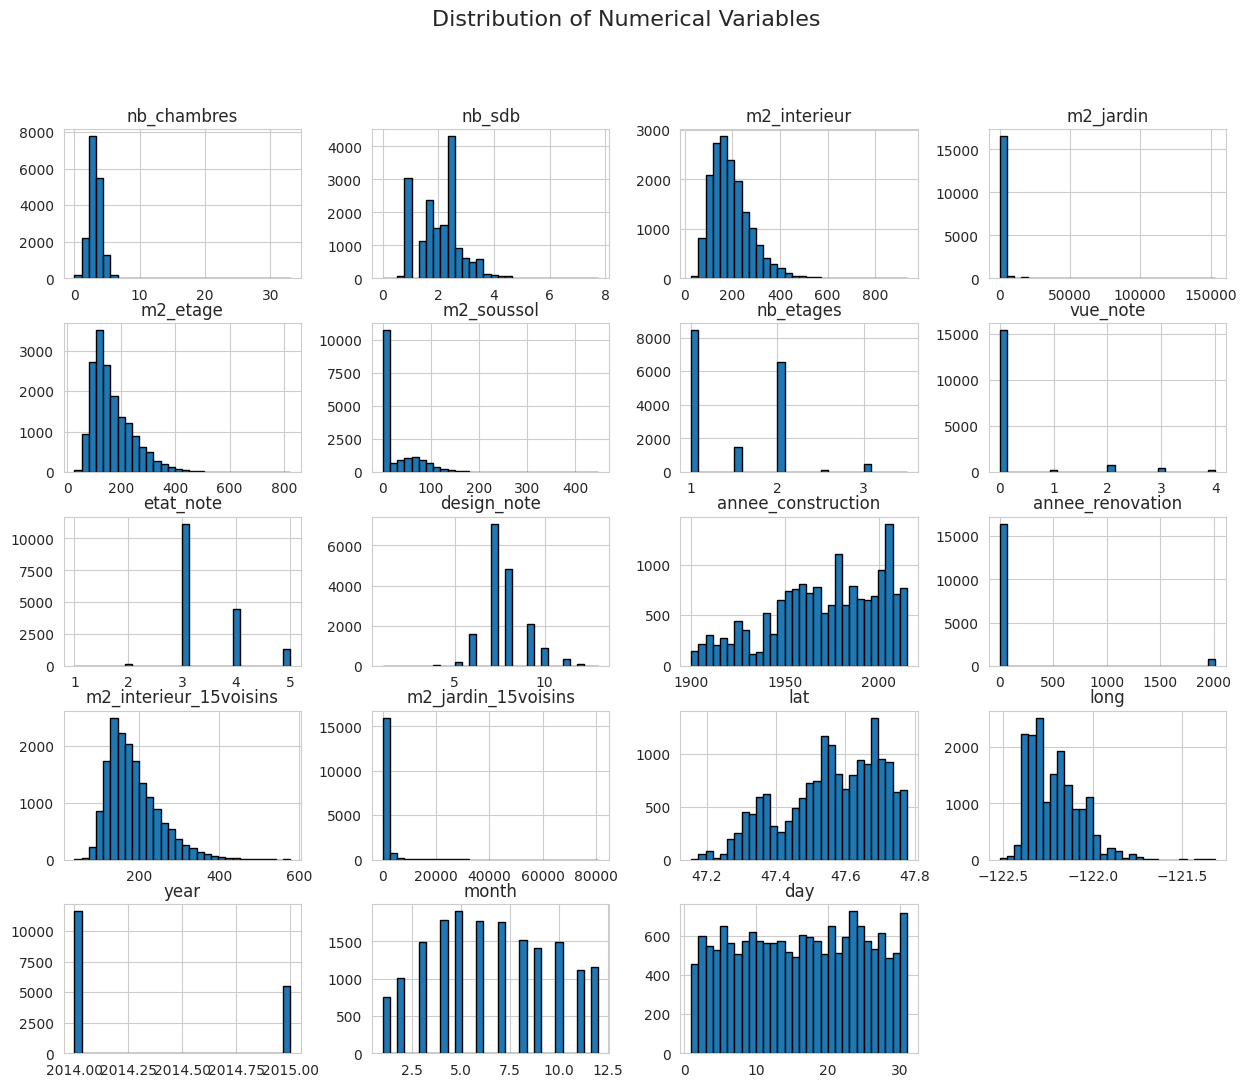

In [7]:
# Set the style
sns.set_style("whitegrid")

# Create subplots
X_quant.hist(figsize=(15, 12), bins=30, edgecolor="black", layout=(5, 4))

# Display the plots
plt.suptitle("Distribution of Numerical Variables", fontsize=16)
plt.show()


In [8]:
# Checking the frequency of each value in the 'year' column
train_df_new['year'].value_counts()

train_df_new['annee_renovation'].value_counts()


annee_renovation
0       16407
2014       75
2013       31
2005       31
2003       28
        ...  
1951        1
1954        1
1940        1
1946        1
1959        1
Name: count, Length: 68, dtype: int64

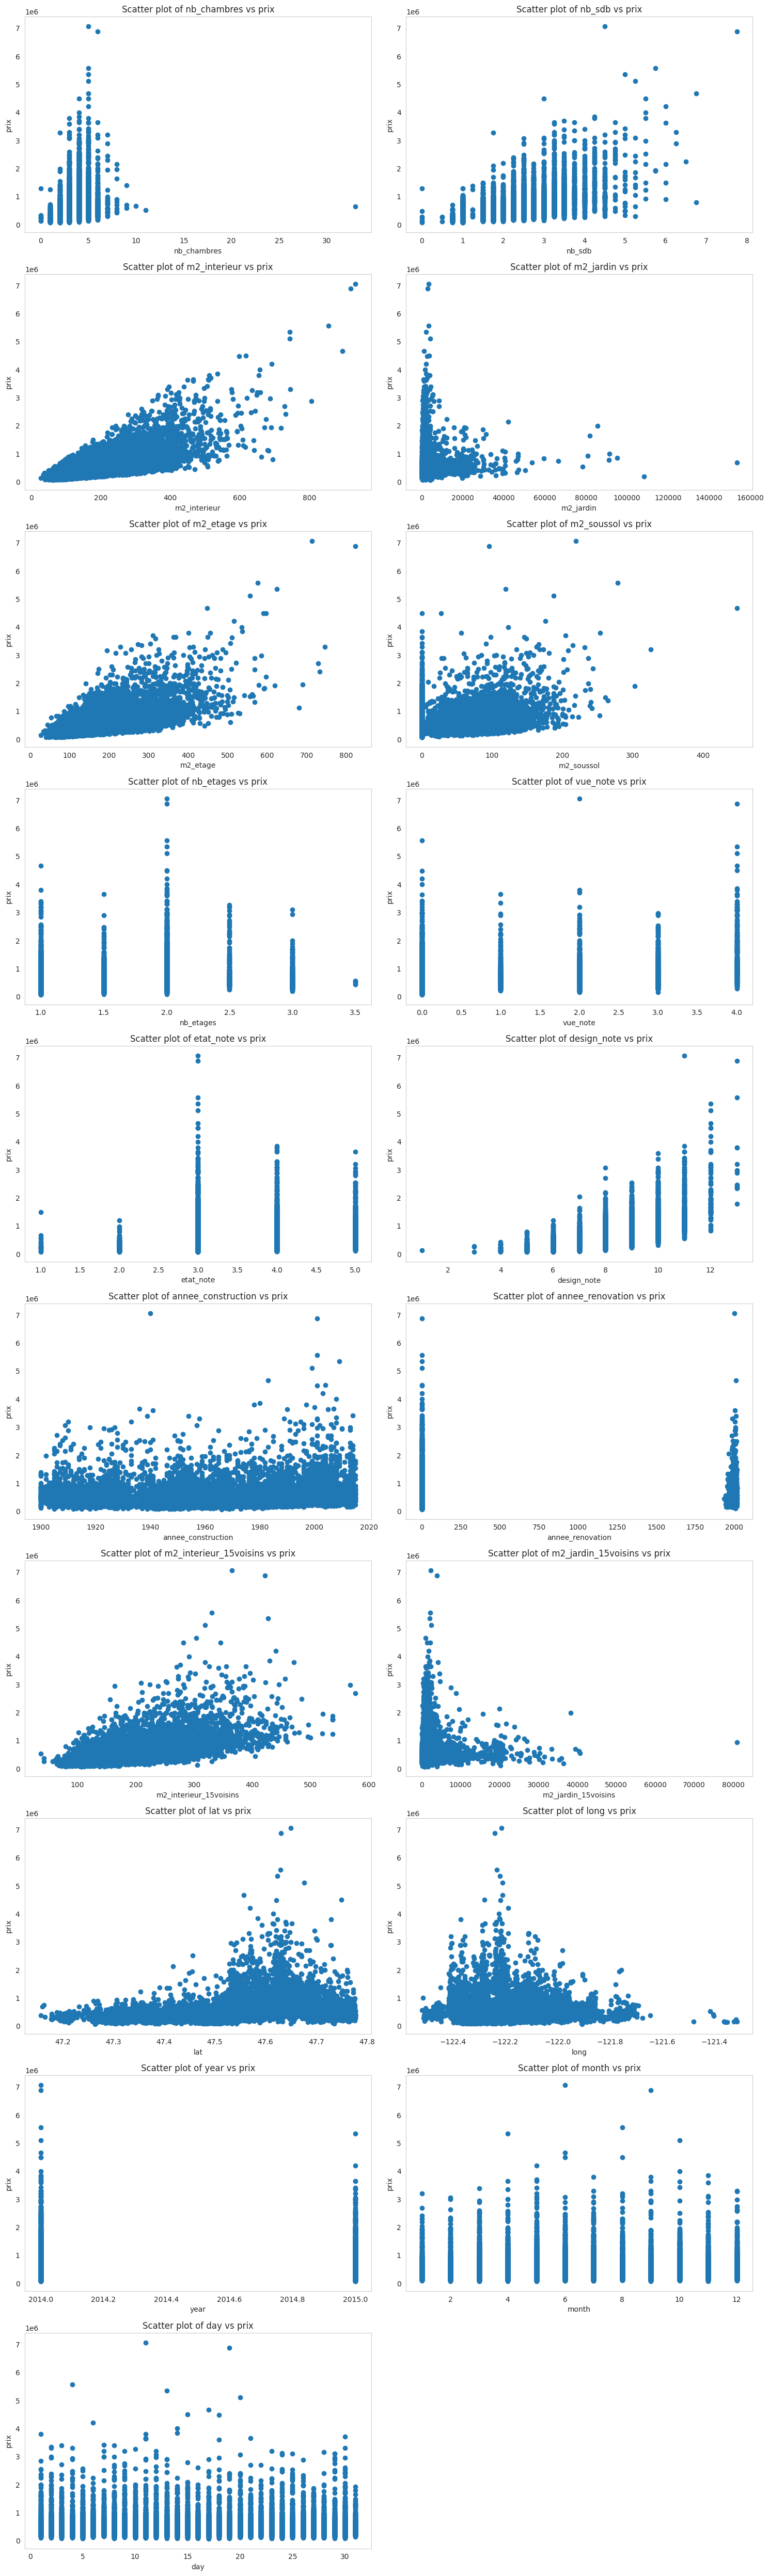

In [9]:
# List of X_quant variables (features you want to visualize)
covariables = X_quant.columns

# Calculate the number of subplots required based on the number of variables
n_vars = len(covariables)
n_rows = math.ceil(n_vars / 2)  # Two columns per row

# Create subplots with dynamic number of rows and two columns
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 5 * n_rows))

# Flatten the axes array to easily iterate through it
axes = axes.flatten()

# Loop through each quantitative variable and create a scatter plot with prix
for i, var in enumerate(covariables):
    axes[i].scatter(train_df_new[var], train_df_new['prix'])
    axes[i].grid()
    axes[i].set_title(f'Scatter plot of {var} vs prix')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('prix')

# Remove any empty subplots (if the number of variables isn't a multiple of 2)
for j in range(n_vars, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


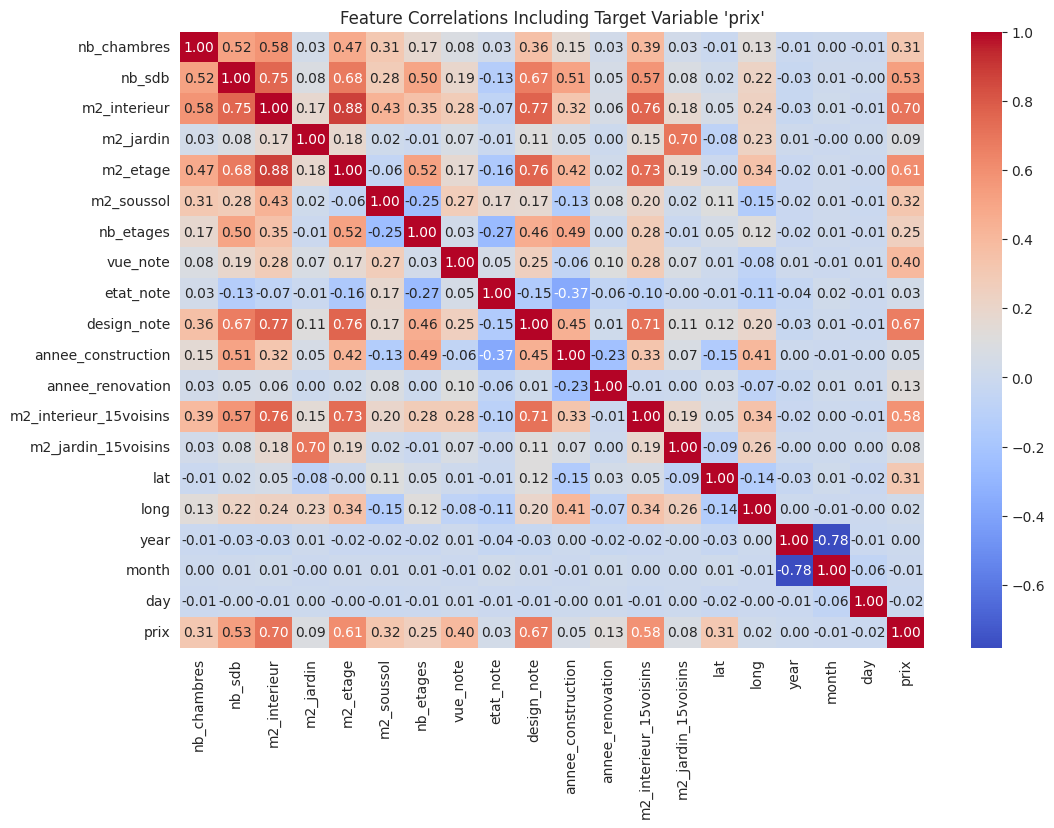

In [10]:
correlation_data = pd.concat([X_quant, y], axis=1)

# Creating the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations Including Target Variable 'prix'")
plt.show()

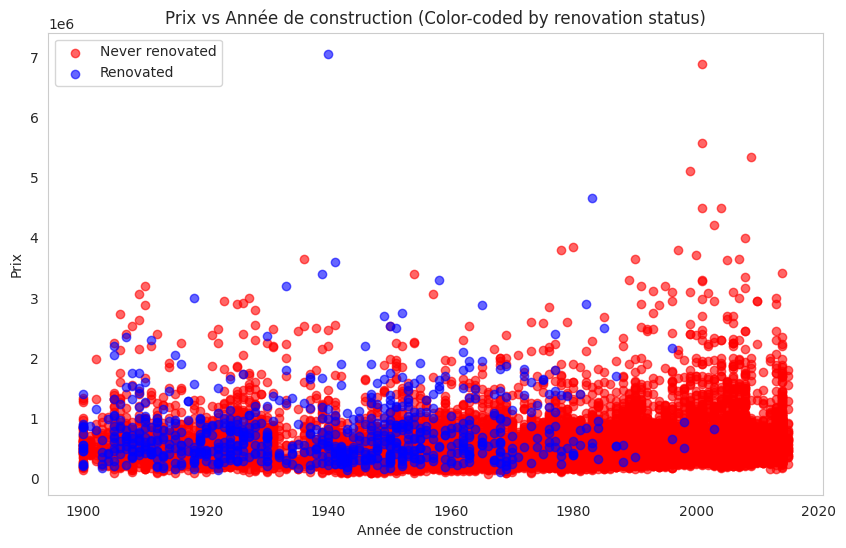

In [11]:
# Separate the data into two groups
never_renovated = train_df_new[train_df_new["annee_renovation"] == 0]
renovated = train_df_new[train_df_new["annee_renovation"] != 0]

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Plot never renovated houses in red
plt.scatter(never_renovated["annee_construction"], never_renovated["prix"],
            color="red", label="Never renovated", alpha=0.6)

# Plot renovated houses in blue
plt.scatter(renovated["annee_construction"], renovated["prix"],
            color="blue", label="Renovated", alpha=0.6)

# Labels and title
plt.xlabel("Année de construction")
plt.ylabel("Prix")
plt.title("Prix vs Année de construction (Color-coded by renovation status)")
plt.legend()
plt.grid()

# Show the plot
plt.show()


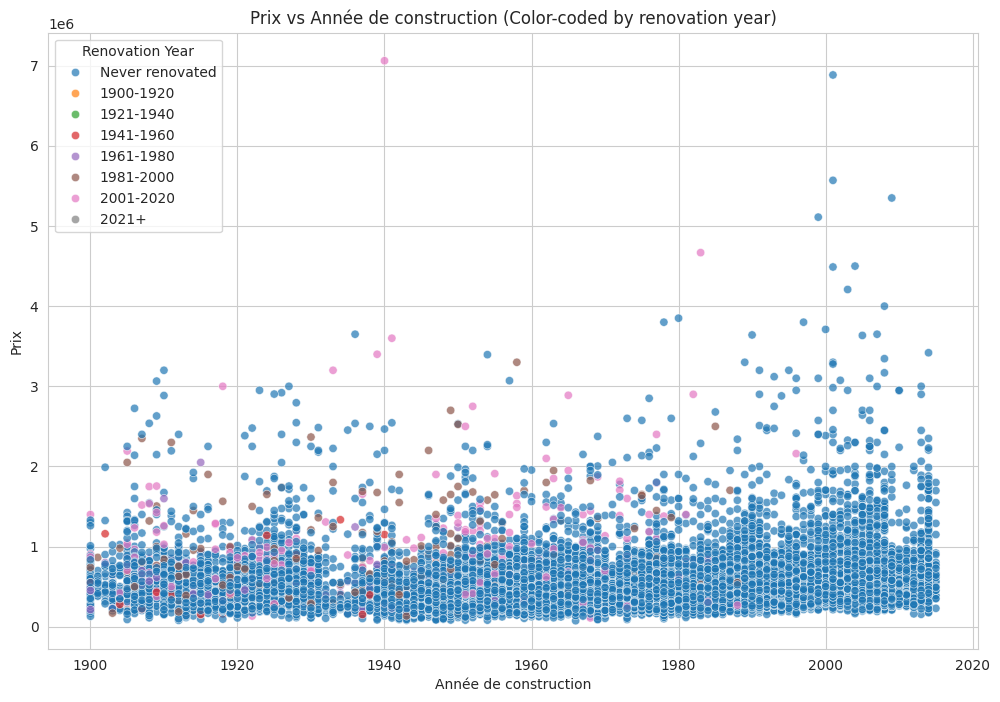

In [12]:
# Define bins for annee_renovation (grouping every 20 years)
bins = [0, 1900, 1920, 1940, 1960, 1980, 2000, 2020, np.inf]
labels = ["Never renovated", "1900-1920", "1921-1940", "1941-1960", "1961-1980", "1981-2000", "2001-2020", "2021+"]

# Assign a category to each house based on annee_renovation
train_df_new["renovation_category"] = pd.cut(train_df_new["annee_renovation"], bins=bins, labels=labels, include_lowest=True)

# Ensure "Never renovated" is explicitly assigned to annee_renovation == 0
train_df_new.loc[train_df_new["annee_renovation"] == 0, "renovation_category"] = "Never renovated"

# Define color palette (8 colors for the 8 categories)
palette = sns.color_palette("tab10", n_colors=len(labels))

# Create scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=train_df_new,
    x="annee_construction",
    y="prix",
    hue="renovation_category",
    palette=palette,
    alpha=0.7  # Transparency for better visibility
)

# Improve plot aesthetics
plt.xlabel("Année de construction")
plt.ylabel("Prix")
plt.title("Prix vs Année de construction (Color-coded by renovation year)")
plt.legend(title="Renovation Year")
plt.grid(True)
plt.show()

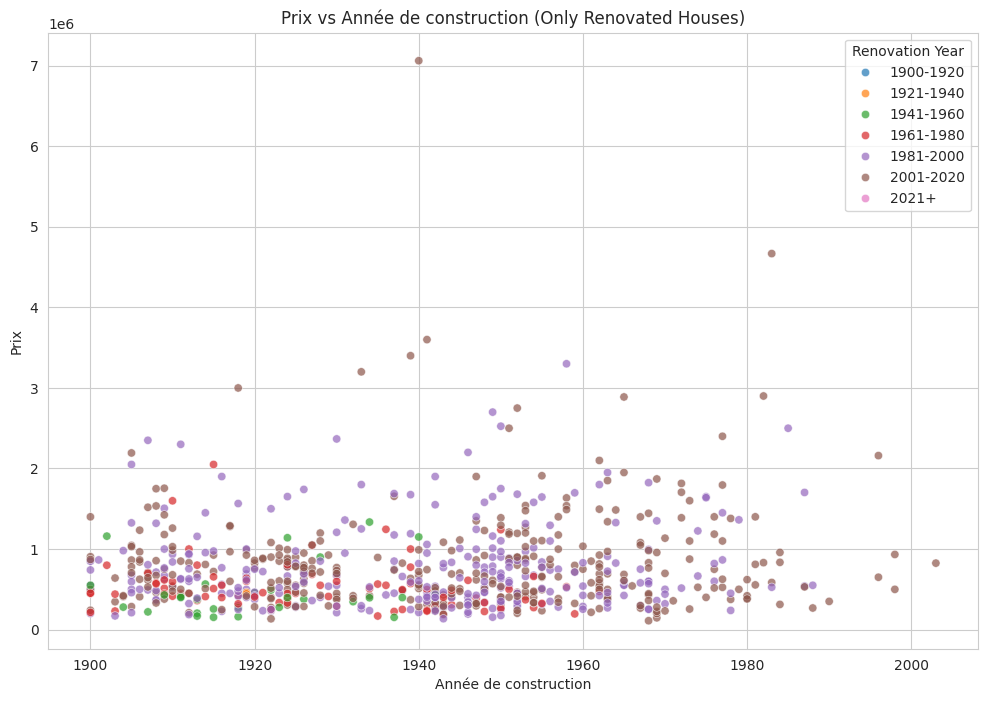

In [13]:
# Filter out houses that were never renovated
renovated_df = train_df_new[train_df_new["annee_renovation"] != 0].copy()

# Define bins for annee_renovation (grouping every 20 years)
bins = [1900, 1920, 1940, 1960, 1980, 2000, 2020, np.inf]
labels = ["1900-1920", "1921-1940", "1941-1960", "1961-1980", "1981-2000", "2001-2020", "2021+"]

# Assign a category to each house based on annee_renovation
renovated_df["renovation_category"] = pd.cut(renovated_df["annee_renovation"], bins=bins, labels=labels, include_lowest=True)

# Define color palette (7 colors for the 7 categories)
palette = sns.color_palette("tab10", n_colors=len(labels))

# Create scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=renovated_df,
    x="annee_construction",
    y="prix",
    hue="renovation_category",
    palette=palette,
    alpha=0.7  # Transparency for better visibility
)

# Improve plot aesthetics
plt.xlabel("Année de construction")
plt.ylabel("Prix")
plt.title("Prix vs Année de construction (Only Renovated Houses)")
plt.legend(title="Renovation Year")
plt.grid(True)
plt.show()


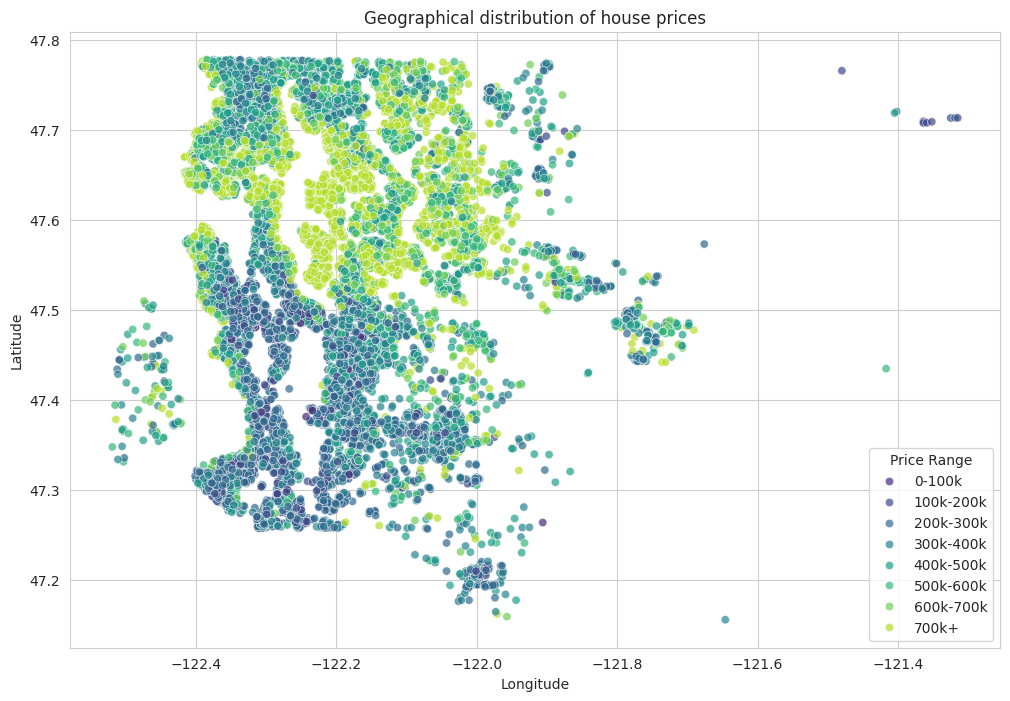

In [14]:
# Define price bins (ranges)
bins = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, np.inf]
labels = ["0-100k", "100k-200k", "200k-300k", "300k-400k", "400k-500k", "500k-600k", "600k-700k", "700k+"]

# Assign a category to each house based on its price
train_df_new["price_category"] = pd.cut(train_df_new["prix"], bins=bins, labels=labels)

# Set color palette (8 different colors)
palette = sns.color_palette("viridis", n_colors=8)

# Create scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=train_df_new,
    x="long",
    y="lat",
    hue="price_category",
    palette=palette,
    alpha=0.7  # Transparency for better visibility
)

# Improve plot aesthetics
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographical distribution of house prices")
plt.legend(title="Price Range")
plt.grid(True)
plt.show()

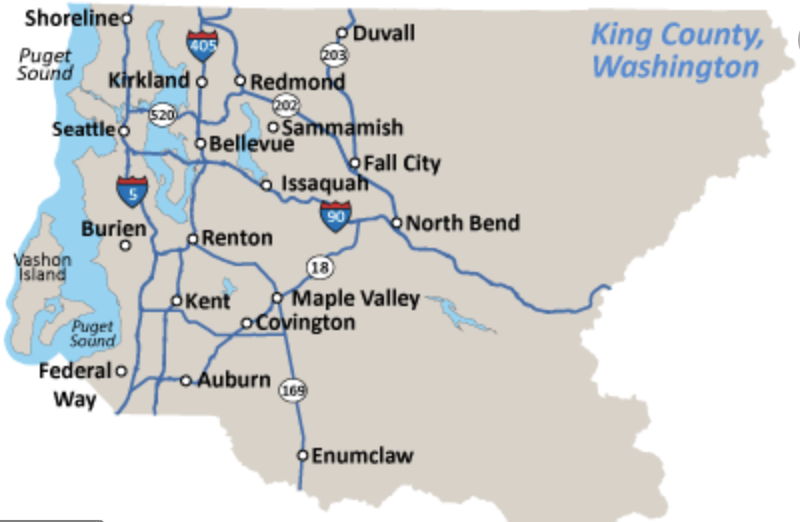

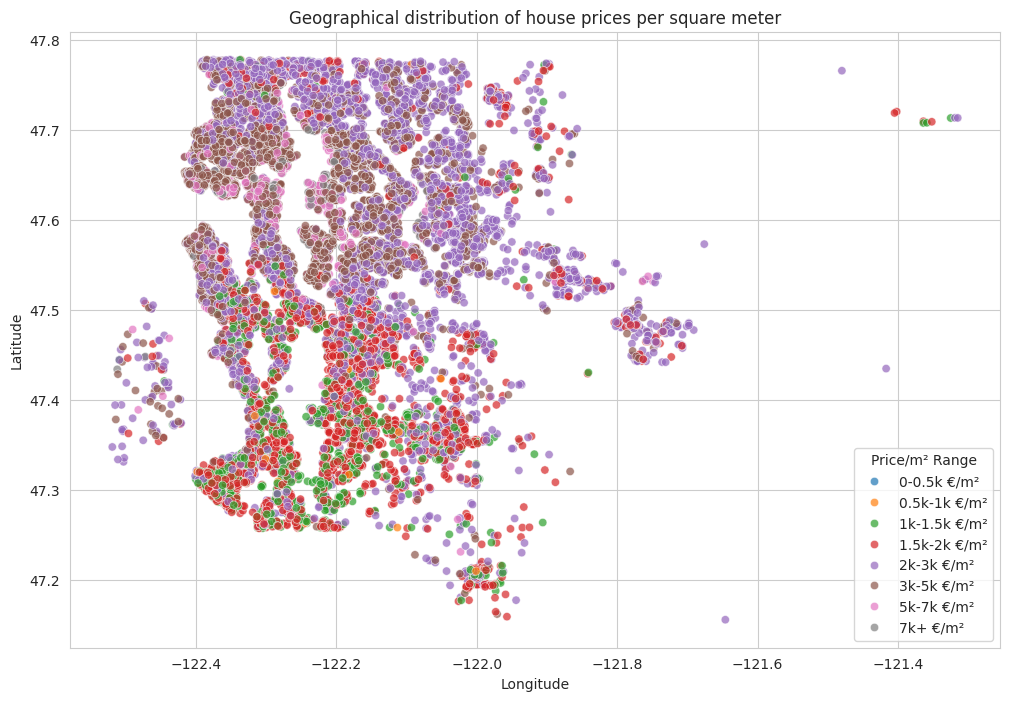

In [15]:
# Calculate price per square meter
train_df_new["prix_m2"] = train_df_new["prix"] / train_df_new["m2_interieur"]

# Define new bin ranges
bins = [0, 500, 1000, 1500, 2000, 3000, 5000, 7000, np.inf]
labels = ["0-0.5k €/m²", "0.5k-1k €/m²", "1k-1.5k €/m²", "1.5k-2k €/m²",
          "2k-3k €/m²", "3k-5k €/m²", "5k-7k €/m²", "7k+ €/m²"]

# Assign categories
train_df_new["price_m2_category"] = pd.cut(train_df_new["prix_m2"], bins=bins, labels=labels)

# Define a more distinct color palette
palette = sns.color_palette("tab10", n_colors=8)  # "Set1" is another option

# Create scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=train_df_new,
    x="long",
    y="lat",
    hue="price_m2_category",
    palette=palette,
    alpha=0.7
)

# Improve aesthetics
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographical distribution of house prices per square meter")
plt.legend(title="Price/m² Range")
plt.grid(True)
plt.show()


# Clustering

In [16]:
# Compute price per square meter for interior and garden
train_df_new["prix_m2_interieur"] = train_df_new["prix"] / train_df_new["m2_interieur"]
train_df_new["prix_m2_jardin"] = train_df_new["prix"] / train_df_new["m2_jardin"]

# Group by zipcode and compute mean and variance
stats_by_zipcode = train_df_new.groupby("zipcode").agg(
    prix_m2_interieur_mean=("prix_m2_interieur", "mean"),
    prix_m2_interieur_variance=("prix_m2_interieur", "var"),
    prix_m2_jardin_mean=("prix_m2_jardin", "mean"),
    prix_m2_jardin_variance=("prix_m2_jardin", "var")
).reset_index()

# Display the result
print(stats_by_zipcode)


   zipcode  prix_m2_interieur_mean  prix_m2_interieur_variance  \
0    98001             1623.784517                1.304956e+05   
1    98002             1605.186431                1.183805e+05   
2    98003             1685.925953                1.208578e+05   
3    98004             5132.919356                1.772426e+06   
4    98005             3389.999665                5.433891e+05   
..     ...                     ...                         ...   
65   98177             3142.338533                1.063560e+06   
66   98178             2041.639605                6.805722e+05   
67   98188             1857.821806                2.123412e+05   
68   98198             1922.407226                4.980487e+05   
69   98199             4069.037700                1.093088e+06   

    prix_m2_jardin_mean  prix_m2_jardin_variance  
0            328.005482             4.206099e+04  
1            397.033967             4.527022e+04  
2            358.453011             3.573114e+04  
3  

<ipython-input-16-b7b8904eac02>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_by_zipcode = train_df_new.groupby("zipcode").agg(


In [17]:
# Avoid division by zero or extreme values
train_df_new = train_df_new[(train_df_new["m2_interieur"] > 1)]

# Compute price per square meter for interior and garden
train_df_new["prix_m2_interieur"] = train_df_new["prix"] / train_df_new["m2_interieur"]

# Group by zipcode and compute mean and standard deviation explicitly
stats_by_zipcode = train_df_new.groupby("zipcode").agg(
    prix_m2_interieur_mean=("prix_m2_interieur", "mean"),
    prix_m2_interieur_std=("prix_m2_interieur", lambda x: np.std(x, ddof=1)),  # Sample standard deviation
).reset_index()

# Display the result
print(stats_by_zipcode)



   zipcode  prix_m2_interieur_mean  prix_m2_interieur_std
0    98001             1623.784517             361.241691
1    98002             1605.186431             344.064626
2    98003             1685.925953             347.646034
3    98004             5132.919356            1331.324886
4    98005             3389.999665             737.149318
..     ...                     ...                    ...
65   98177             3142.338533            1031.290238
66   98178             2041.639605             824.967989
67   98188             1857.821806             460.804924
68   98198             1922.407226             705.725625
69   98199             4069.037700            1045.508633

[70 rows x 3 columns]


<ipython-input-17-c8d1234f9200>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_by_zipcode = train_df_new.groupby("zipcode").agg(


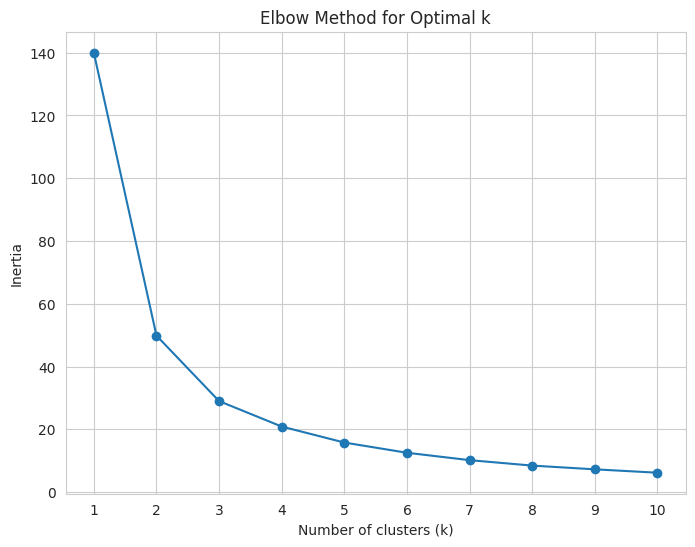

In [18]:
# Prepare the data for clustering
X = stats_by_zipcode[["prix_m2_interieur_mean", "prix_m2_interieur_std"]]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method to determine the optimal number of clusters
inertia = []  # List to store the inertia values
k_range = range(1, 11)  # Test for k values from 1 to 10

for k in k_range:
    kmeans = KMeans(init='k-means++', max_iter=300, n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # Store the inertia (sum of squared distances to centroids)

# Plot the inertia to visualize the elbow
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)  # Ensure x-axis has all k values
plt.grid(True)
plt.show()

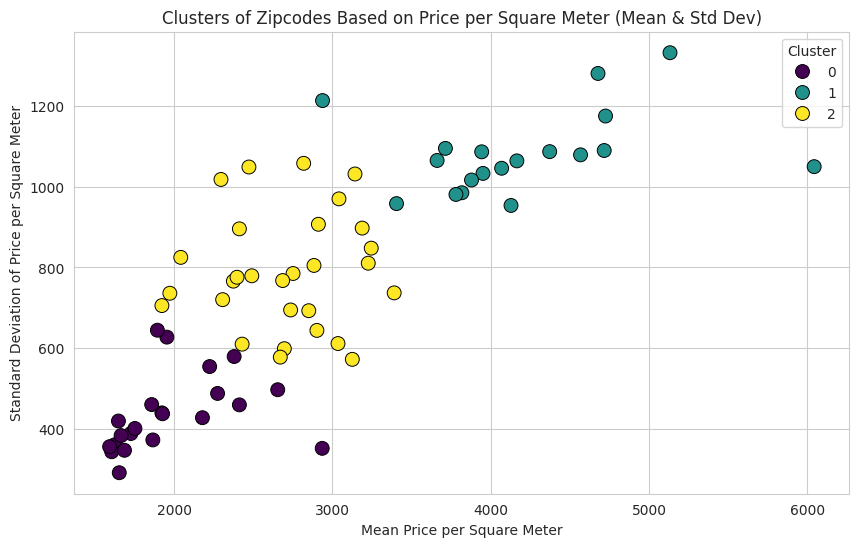

   zipcode  prix_m2_interieur_mean  prix_m2_interieur_std  cluster
0    98001             1623.784517             361.241691        0
1    98002             1605.186431             344.064626        0
2    98003             1685.925953             347.646034        0
3    98004             5132.919356            1331.324886        1
4    98005             3389.999665             737.149318        2
..     ...                     ...                    ...      ...
65   98177             3142.338533            1031.290238        2
66   98178             2041.639605             824.967989        2
67   98188             1857.821806             460.804924        0
68   98198             1922.407226             705.725625        2
69   98199             4069.037700            1045.508633        1

[70 rows x 4 columns]


In [19]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
stats_by_zipcode['cluster'] = kmeans.fit_predict(X_scaled)

train_df_clustered = train_df_new.merge(stats_by_zipcode[['zipcode', 'cluster']], on='zipcode', how='left')


# Save clustering results for later use
for cluster_id in range(3):
    cluster_data = train_df_clustered[train_df_clustered['cluster'] == cluster_id]
    cluster_data.to_csv(f"cluster_{cluster_id}.csv", index=False)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=stats_by_zipcode,
    x="prix_m2_interieur_mean",
    y="prix_m2_interieur_std",
    hue="cluster",
    palette="viridis",
    s=100,
    edgecolor='black',
    linewidth=0.7
)
plt.title("Clusters of Zipcodes Based on Price per Square Meter (Mean & Std Dev)")
plt.xlabel("Mean Price per Square Meter")
plt.ylabel("Standard Deviation of Price per Square Meter")
plt.legend(title="Cluster")
plt.show()

# Display the clusters with zipcodes
print(stats_by_zipcode)



In [20]:
print(train_df_clustered.head())  # Verify if "test_df" has the cluster column

           id    prix  nb_chambres  nb_sdb  m2_interieur    m2_jardin  \
0  4443800785  481000            2    1.00    150.501672   360.460795   
1  2722059013  550000            2    1.00    117.985879  4046.822742   
2  8856004730  199950            2    2.75    147.714604  1943.236715   
3  2473003210  364808            3    1.75    215.533259   731.605351   
4  6743700335  470000            3    2.00    167.224080  1176.978818   

     m2_etage  m2_soussol  nb_etages  vue_mer  ...  year  month  day  \
0   85.470085   65.031587        1.0        0  ...  2014     11   21   
1  117.985879    0.000000        1.0        0  ...  2015      2    4   
2  147.714604    0.000000        1.5        0  ...  2014      9   17   
3  150.501672   65.031587        1.0        0  ...  2015      3   13   
4  167.224080    0.000000        1.0        0  ...  2014      6    4   

   renovation_category  price_category      prix_m2  price_m2_category  \
0      Never renovated       400k-500k  3195.977778   

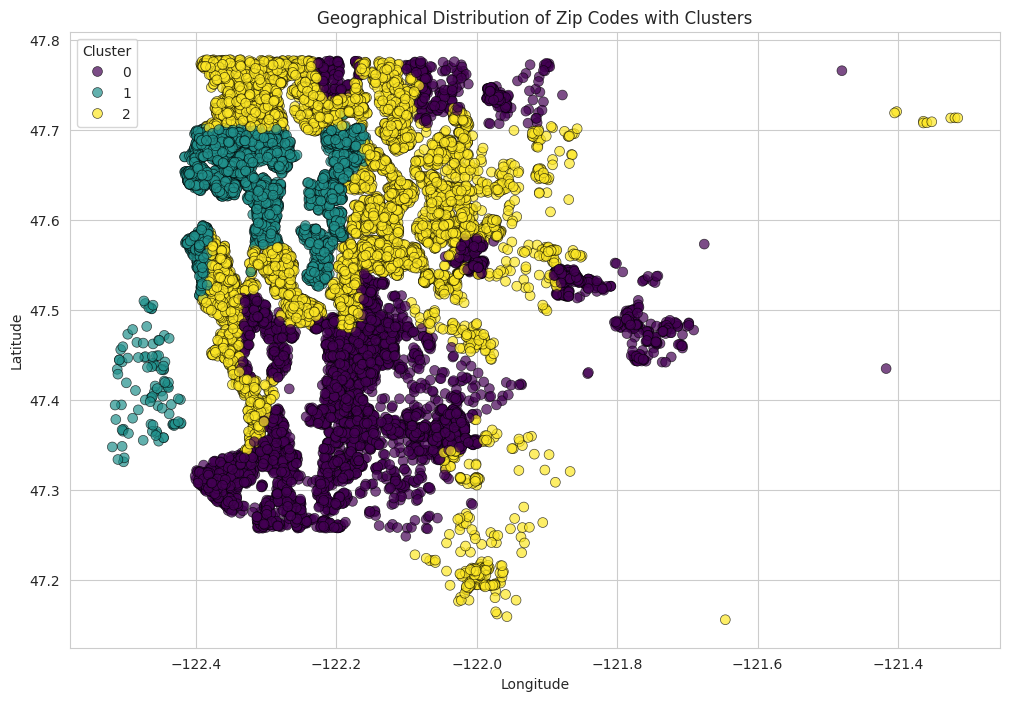

In [21]:
# Create scatter plot with longitude and latitude, colored by cluster
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data = train_df_clustered,  # Use the new dataframe with cluster info
    x="long",
    y="lat",
    hue="cluster",
    palette="viridis",
    s=50,
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5
)

# Improve plot aesthetics
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographical Distribution of Zip Codes with Clusters")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

In [22]:
cluster_mapping = train_df_clustered[['zipcode', 'cluster']].drop_duplicates()  # map cluster from the train data

test_df = test_df.merge(cluster_mapping, on="zipcode", how="left") # give clusters to each ap

print(test_df.head())  # Verify if "test_df" has the cluster column





         id                  date  nb_chambres  nb_sdb  m2_interieur  \
0   3600072  2015-03-30T00:00:00Z            4    2.75    206.243032   
1   6200017  2014-11-12T00:00:00Z            3    1.00    124.489038   
2   7600136  2014-07-18T00:00:00Z            2    2.00    104.979562   
3  11200400  2014-09-23T00:00:00Z            3    2.50    177.443330   
4  11500890  2015-03-12T00:00:00Z            3    2.50    290.784095   

     m2_jardin    m2_etage  m2_soussol  nb_etages  vue_mer  ...  etat_note  \
0   493.311037  108.695652   97.547380        1.0        0  ...          5   
1  1982.162765  124.489038    0.000000        1.5        0  ...          4   
2   106.651802   74.321813   30.657748        2.0        0  ...          3   
3   416.945373  177.443330    0.000000        2.0        0  ...          3   
4   812.894835  290.784095    0.000000        2.0        0  ...          3   

   design_note  annee_construction  annee_renovation  m2_interieur_15voisins  \
0            7    

<Axes: xlabel='long', ylabel='lat'>

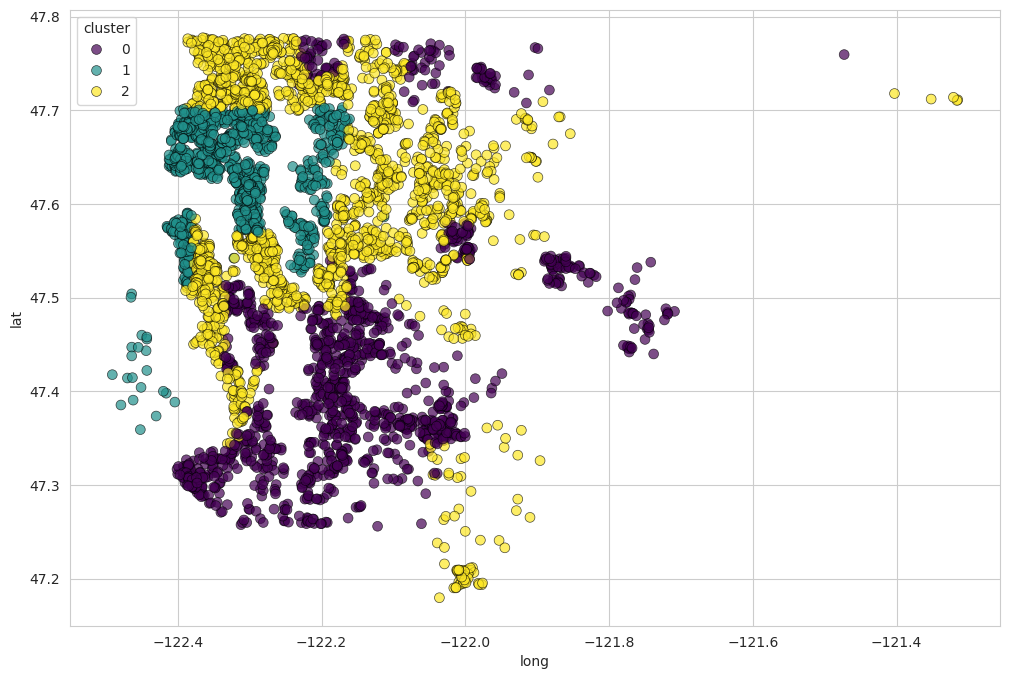

In [23]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data = test_df,  # Use the new dataframe with cluster info
    x="long",
    y="lat",
    hue="cluster",
    palette="viridis",
    s=50,
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5
)

# Régression lineaire

## Fonctions

### Calculs des AIC et BIC

In [24]:
def AIC_BIC_linreg(X, y, features):
    linreg_model = OLS(y, X[list(features)])
    linreg = linreg_model.fit()
    AIC = linreg.aic
    BIC = linreg.bic
    return {'model':linreg, 'AIC':AIC, 'BIC':BIC}

### Procédure backward

In [25]:
def linreg_backward_predictors(X, y, predictors, crit='BIC', verbose=True):
    results = []

    for combi in itertools.combinations(predictors, len(predictors)-1):
        results.append(AIC_BIC_linreg(X=X, y=y, features=list(combi)+['const']))
    models = pd.DataFrame(results)

    if crit == 'AIC':
        best_model = models.loc[models['AIC'].argmin()]
    else:
        best_model = models.loc[models['BIC'].argmin()]

    if verbose == True:
        print('Selected predictors:', best_model['model'].model.exog_names, 'AIC:', best_model['model'].aic, 'BIC:', best_model['model'].bic)

    return best_model

In [26]:
def linreg_backward_proc(X, y, crit='BIC', verbose=True):
    backward_models = pd.DataFrame(columns=['AIC', 'BIC', 'model'])
    predictors = list(X.columns.difference(['const']))

    for i in range(1, len(X.columns.difference(['const'])) + 1):
        backward_result = linreg_backward_predictors(X=X, y=y, predictors=predictors, crit=crit, verbose=verbose)
        if i > 1:
            if backward_result[crit] > backward_model_before:
                break
        backward_models.loc[i] = backward_result
        predictors = backward_models.loc[i]['model'].model.exog_names
        backward_model_before = backward_models.loc[i][crit]
        predictors = [k for k in predictors if k != 'const']

    return(backward_models['model'][len(backward_models['model'])])

### Procédure forward

In [27]:
def linreg_forward_predictors(X, y, predictors, crit='BIC', verbose=True):
    results=[]
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]

    for p in remaining_predictors:
        results.append(AIC_BIC_linreg(X=X, y=y, features=predictors+[p]+['const']))
    models = pd.DataFrame(results)

    if crit == 'AIC':
        best_model = models.loc[models['AIC'].argmin()]
    else:
        best_model = models.loc[models['BIC'].argmin()]

    if verbose == True:
        print('Selected predictors:', best_model['model'].model.exog_names, 'AIC:', best_model['model'].aic, 'BIC:', best_model['model'].bic)

    return best_model

In [28]:
def linreg_forward_proc(X, y, crit='BIC', verbose=True):
    forward_models = pd.DataFrame(columns=['AIC', 'BIC', 'model'])
    predictors = []

    for i in range(1, len(X.columns.difference(['const'])) + 1):
        forward_result = linreg_forward_predictors(X=X, y=y, predictors=predictors, crit=crit, verbose=verbose)
        if i > 1:
            if forward_result[crit] > forward_model_before:
                break
        forward_models.loc[i] = forward_result
        predictors = forward_models.loc[i]['model'].model.exog_names
        forward_model_before = forward_models.loc[i][crit]
        predictors = [k for k in predictors if k != 'const']

    return(forward_models['model'][len(forward_models['model'])])

### Procédure stepwise

In [29]:
def linreg_stepwise_proc(X, y, crit='BIC', verbose=True):
    stepwise_models = pd.DataFrame(columns=['AIC', 'BIC', 'model'])
    predictors = []
    stepwise_model_before = AIC_BIC_linreg(X, y, predictors+['const'])[crit]

    for i in range(1, len(X.columns.difference(['const'])) + 1):
        forward_result = linreg_forward_predictors(X=X, y=y, predictors=predictors, crit=crit, verbose=verbose)
        stepwise_models.loc[i] = forward_result
        predictors = stepwise_models.loc[i]['model'].model.exog_names
        predictors = [k for k in predictors if k != 'const']
        backward_result = linreg_backward_predictors(X=X, y=y, predictors=predictors, crit=crit, verbose=verbose)
        if backward_result[crit]< forward_result[crit]:
            stepwise_models.loc[i] = backward_result
            predictors = stepwise_models.loc[i]['model'].model.exog_names
            stepwise_model_before = stepwise_models.loc[i][crit]
            predictors = [k for k in predictors if k != 'const']
        if stepwise_models.loc[i][crit]> stepwise_model_before:
            break
        else:
            stepwise_model_before = stepwise_models.loc[i][crit]

    return(stepwise_models['model'][len(stepwise_models['model'])])


## 3.1. Régression linéaire multiple

In [30]:
cluster0_path = "/content/cluster_0.csv"
cluster1_path = "/content/cluster_1.csv"
cluster2_path = "/content/cluster_2.csv"

cluster0 = pd.read_csv(cluster0_path)
cluster1 = pd.read_csv(cluster1_path)
cluster2 = pd.read_csv(cluster2_path)

In [31]:
var_y = 'prix'
y0 = cluster0[var_y]
y1 = cluster1[var_y]
y2 = cluster2[var_y]

var_X = ['nb_chambres', 'nb_sdb', 'm2_interieur', 'm2_jardin', 'm2_etage', 'm2_soussol', 'nb_etages', 'vue_note', 'design_note', 'etat_note', 'm2_interieur_15voisins', 'm2_jardin_15voisins']
X0 = cluster0[var_X]
X1 = cluster1[var_X]
X2 = cluster2[var_X]


In [32]:
# Linear regression for cluster 0
linreg_model0 = sm.OLS(y0, sm.add_constant(X0))
model0 = linreg_model0.fit()
print("Results for model 0:")
model0.summary()


Results for model 0:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prix   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     1210.
Date:                Sun, 20 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:25:03   Log-Likelihood:                -67243.
No. Observations:                5209   AIC:                         1.345e+05
Df Residuals:                    5197   BIC:                         1.346e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -2.891e+05   1.69e+04    -17.118      0.000   -3.22e+05   -2.56e+05
nb_chambres            -2.094e+04   2233.855     -9.372      0.000   -2.53e+04   -1.66e+04
nb_sdb                  1.254e+04   3496.177      3.587      0.000    5688.456    1.94e+04
m2_interieur             572.7885     27.567     20.778      0.000     518.746     626.831
m2_jardin                  5.9377      0.451     13.179      0.000       5.054       6.821
m2_etage                 522.0803     27.304     19.121      0.000     468.553     575.608
m2_soussol                50.7082     33.330      1.521      0.128     -14.632     116.048
nb_etages              -6360.8490   4362.584     -1.458      0.145   -1.49e+04    2191.651
vue_note                1.343e+04   3083.865      4.355      0.000    7384.072    1.95e+04
design_note             4.726e+04   2200.119     21.479      0.000    4.29e+04    5.16e+04
etat_note               1.098e+04   2561.908      4.285      0.000    5954.641     1.6e+04
m2_interieur_15voisins   549.7561     42.372     12.975      0.000     466.690     632.822
m2_jardin_15voisins        1.8366      0.680      2.700      0.007       0.503       3.170
==============================================================================
Omnibus:                     1788.735   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17478.521
Skew:                           1.355   Prob(JB):                         0.00
Kurtosis:                      11.555   Cond. No.                     4.11e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.62e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# Linear regression for cluster 1
linreg_model0 = sm.OLS(y1, sm.add_constant(X1))
model1 = linreg_model0.fit()
print("Results for model 1:")
model1.summary()


Results for model 1:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prix   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     1373.
Date:                Sun, 20 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:25:05   Log-Likelihood:                -62272.
No. Observations:                4512   AIC:                         1.246e+05
Df Residuals:                    4500   BIC:                         1.246e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -5.781e+05   3.85e+04    -15.014      0.000   -6.54e+05   -5.03e+05
nb_chambres            -3.465e+04   4080.319     -8.493      0.000   -4.27e+04   -2.67e+04
nb_sdb                  3848.7443   7056.944      0.545      0.586   -9986.333    1.77e+04
m2_interieur            1920.8729     55.531     34.591      0.000    1812.004    2029.742
m2_jardin                 -3.7806      2.190     -1.726      0.084      -8.074       0.513
m2_etage                1936.8944     59.458     32.576      0.000    1820.327    2053.462
m2_soussol               -16.0214     69.731     -0.230      0.818    -152.727     120.685
nb_etages              -8.475e+04   7787.500    -10.883      0.000      -1e+05   -6.95e+04
vue_note                4.756e+04   4347.801     10.939      0.000     3.9e+04    5.61e+04
design_note             7.881e+04   5423.852     14.531      0.000    6.82e+04    8.94e+04
etat_note               2.298e+04   5234.139      4.391      0.000    1.27e+04    3.32e+04
m2_interieur_15voisins  1227.8661     88.784     13.830      0.000    1053.806    1401.926
m2_jardin_15voisins       -9.6519      3.100     -3.113      0.002     -15.730      -3.574
==============================================================================
Omnibus:                     2533.524   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            83092.315
Skew:                           2.094   Prob(JB):                         0.00
Kurtosis:                      23.602   Cond. No.                     4.86e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.54e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [35]:
# Linear regression for cluster 2
linreg_model2 = sm.OLS(y2, sm.add_constant(X2))
model2 = linreg_model2.fit()
print("Results for model 2:")
model2.summary()


Results for model 2:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prix   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     1750.
Date:                Sun, 20 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:25:05   Log-Likelihood:                -99565.
No. Observations:                7426   AIC:                         1.992e+05
Df Residuals:                    7414   BIC:                         1.992e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -4.191e+05    2.1e+04    -19.934      0.000    -4.6e+05   -3.78e+05
nb_chambres            -3.218e+04   2657.587    -12.109      0.000   -3.74e+04    -2.7e+04
nb_sdb                  1.116e+04   4159.680      2.682      0.007    3001.802    1.93e+04
m2_interieur             984.6321     33.236     29.625      0.000     919.479    1049.785
m2_jardin                  2.2444      0.611      3.674      0.000       1.047       3.442
m2_etage                 816.8328     32.182     25.381      0.000     753.746     879.919
m2_soussol               167.7994     36.994      4.536      0.000      95.281     240.318
nb_etages              -4.459e+04   5117.090     -8.713      0.000   -5.46e+04   -3.46e+04
vue_note                8.097e+04   2433.307     33.277      0.000    7.62e+04    8.57e+04
design_note             7.086e+04   2853.659     24.832      0.000    6.53e+04    7.65e+04
etat_note                3.25e+04   3031.004     10.722      0.000    2.66e+04    3.84e+04
m2_interieur_15voisins   490.6589     48.947     10.024      0.000     394.709     586.609
m2_jardin_15voisins       -6.7286      0.991     -6.793      0.000      -8.670      -4.787
==============================================================================
Omnibus:                     6392.807   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542186.152
Skew:                           3.680   Prob(JB):                         0.00
Kurtosis:                      44.208   Cond. No.                     1.35e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.08e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## 3.2. Definition prix

In [36]:
cluster_coefficients = {
    0: {"const": -289100, "nb_chambres": -20940, "nb_sdb": 12540, "m2_interieur": 572.79,
        "m2_jardin": 5.94, "m2_etage": 522.08, "m2_soussol": 50.71, "nb_etages": -6360.85,
        "vue_note": 13430, "design_note": 47260, "etat_note": 10980,
        "m2_interieur_15voisins": 549.76, "m2_jardin_15voisins": 1.84},

    1: {"const": -578100, "nb_chambres": -34650, "nb_sdb": 3848.74, "m2_interieur": 1920.87,
        "m2_jardin": -3.78, "m2_etage": 1936.89, "m2_soussol": -16.02, "nb_etages": -84750,
        "vue_note": 47560, "design_note": 78810, "etat_note": 22980,
        "m2_interieur_15voisins": 1227.87, "m2_jardin_15voisins": -9.65},

    2: {"const": -419100, "nb_chambres": -32180, "nb_sdb": 11160, "m2_interieur": 984.63,
        "m2_jardin": 2.24, "m2_etage": 816.83, "m2_soussol": 167.80, "nb_etages": -44590,
        "vue_note": 80970, "design_note": 70860, "etat_note": 32500,
        "m2_interieur_15voisins": 490.66, "m2_jardin_15voisins": -6.73}
}

features = ["nb_chambres", "nb_sdb", "m2_interieur", "m2_jardin", "m2_etage", "m2_soussol",
            "nb_etages", "vue_note", "design_note", "etat_note",
            "m2_interieur_15voisins", "m2_jardin_15voisins"]

test_df["predicted_prix"] = 0

for cluster_id, coefs in cluster_coefficients.items():
    # Filtrar os dados pertencentes a esse cluster
    cluster_data = test_df[test_df["cluster"] == cluster_id]

    if not cluster_data.empty:
        # Criar matriz de variáveis independentes com a constante
        X_cluster = cluster_data[features]
        X_cluster = sm.add_constant(X_cluster)

        # Aplicar os coeficientes do cluster correspondente
        test_df.loc[test_df["cluster"] == cluster_id, "predicted_prix"] = X_cluster.dot(pd.Series(coefs))

# Passo 5: Salvar os resultados
test_df.to_csv(f"test_data_with_predictions.csv", index=False)

test_df[['id', 'predicted_prix']].rename(columns={'predicted_prix': 'prix'}).to_csv("test_predictions.csv", index=False)




<ipython-input-36-3e5d32f90a97>:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[154256.1348848  143244.62751765 171477.92554812 ... 533730.42188777
 559922.2427722  315366.0229097 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_df.loc[test_df["cluster"] == cluster_id, "predicted_prix"] = X_cluster.dot(pd.Series(coefs))


In [37]:
final_path = "/content/test_data_with_predictions.csv"
final_df = pd.read_csv(final_path)

Cluster count:
cluster
0    1305
1    1101
2    1881
Name: count, dtype: int64

Cluster pourcentage
cluster
0    30.44
1    25.68
2    43.88
Name: proportion, dtype: float64


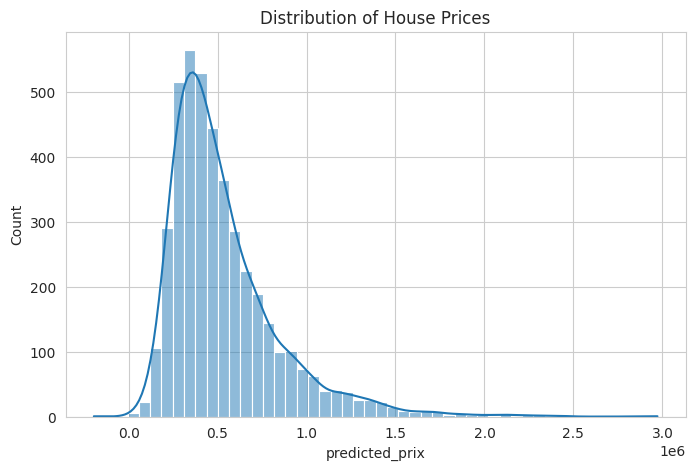

In [38]:
final_df = pd.read_csv(final_path)
yf = final_df["predicted_prix"]
cluster_counts = final_df["cluster"].value_counts().sort_index()
cluster_ratios = final_df["cluster"].value_counts(normalize=True).sort_index() * 100
print("Cluster count:")
print(cluster_counts)
print("\nCluster pourcentage")
print(cluster_ratios.round(2))
plt.figure(figsize=(8,5))
sns.histplot(yf, bins=50, kde=True)
plt.title("Distribution of House Prices")
plt.show()

In [39]:
print(test_df.head())  # Verify if "test_df" has the cluster column

#final_df[['id', 'predicted_prix']].to_csv(f"test_predictions.csv", index=False)

         id                  date  nb_chambres  nb_sdb  m2_interieur  \
0   3600072  2015-03-30T00:00:00Z            4    2.75    206.243032   
1   6200017  2014-11-12T00:00:00Z            3    1.00    124.489038   
2   7600136  2014-07-18T00:00:00Z            2    2.00    104.979562   
3  11200400  2014-09-23T00:00:00Z            3    2.50    177.443330   
4  11500890  2015-03-12T00:00:00Z            3    2.50    290.784095   

     m2_jardin    m2_etage  m2_soussol  nb_etages  vue_mer  ...  design_note  \
0   493.311037  108.695652   97.547380        1.0        0  ...            7   
1  1982.162765  124.489038    0.000000        1.5        0  ...            5   
2   106.651802   74.321813   30.657748        2.0        0  ...            9   
3   416.945373  177.443330    0.000000        2.0        0  ...            8   
4   812.894835  290.784095    0.000000        2.0        0  ...           10   

   annee_construction  annee_renovation  m2_interieur_15voisins  \
0                19

<Axes: xlabel='long', ylabel='lat'>

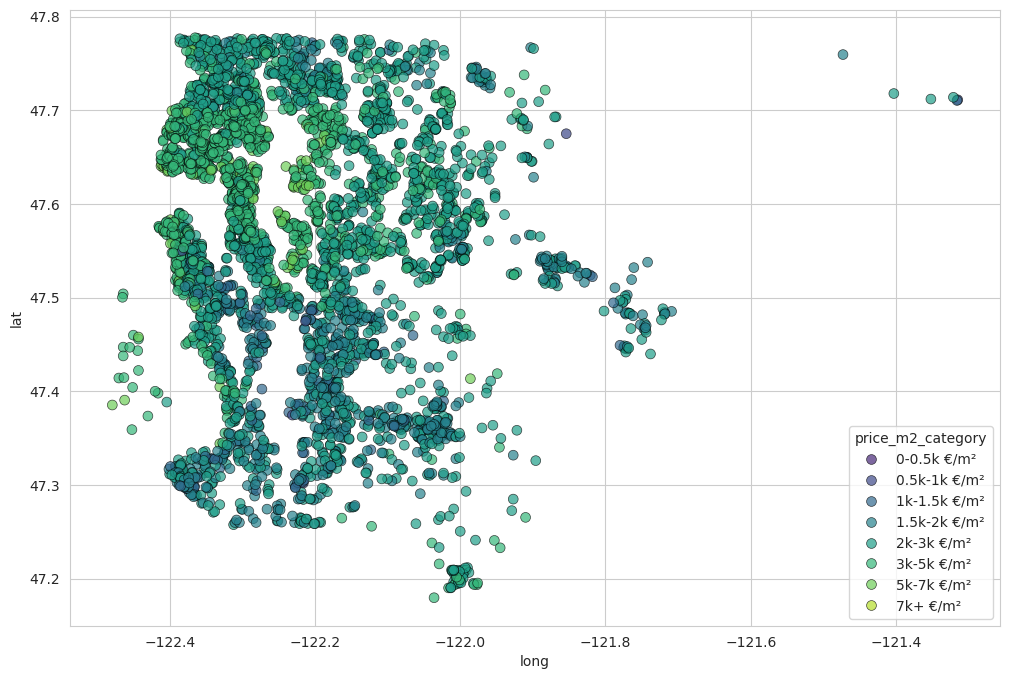

In [40]:
# Calculate price per square meter
final_df["prix_m2"] = final_df["predicted_prix"] / final_df["m2_interieur"]

# Define new bin ranges
bins = [0, 500, 1000, 1500, 2000, 3000, 5000, 7000, np.inf]
labels = ["0-0.5k €/m²", "0.5k-1k €/m²", "1k-1.5k €/m²", "1.5k-2k €/m²",
          "2k-3k €/m²", "3k-5k €/m²", "5k-7k €/m²", "7k+ €/m²"]

# Assign categories
final_df["price_m2_category"] = pd.cut(final_df["prix_m2"], bins=bins, labels=labels)

# Define a more distinct color palette
palette = sns.color_palette("tab10", n_colors=8)  # "Set1" is another option

plt.figure(figsize=(12, 8))

sns.scatterplot(
    data = final_df,  # Use the new dataframe with cluster info
    x="long",
    y="lat",
    hue="price_m2_category",
    palette="viridis",
    s=50,
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5
)

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import math

features = ["nb_chambres", "nb_sdb", "m2_interieur", "m2_jardin", "m2_etage", "m2_soussol",
            "nb_etages", "vue_note", "design_note", "etat_note",
            "m2_interieur_15voisins", "m2_jardin_15voisins"]

test_df["predicted_prix"] = 0

# 用于存储每个 cluster 的平均误差
cluster_mae_all = []
cluster_rmse_all = []

N_REPEAT = 5  # 重复抽样次数

for cluster_id in train_df_clustered["cluster"].unique():
    train_cluster = train_df_clustered[train_df_clustered["cluster"] == cluster_id]
    test_cluster = test_df[test_df["cluster"] == cluster_id]

    if not train_cluster.empty:
        X = train_cluster[features]
        y = train_cluster["prix"]

        mae_list = []
        rmse_list = []

        for seed in range(N_REPEAT):
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

            rf = RandomForestRegressor(n_estimators=200, random_state=0)
            rf.fit(X_train, y_train)

            val_preds = rf.predict(X_val)
            mae = mean_absolute_error(y_val, val_preds)
            rmse = math.sqrt(mean_squared_error(y_val, val_preds))

            mae_list.append(mae)
            rmse_list.append(rmse)

        # 每个 cluster 的平均误差
        mean_mae = np.mean(mae_list)
        mean_rmse = np.mean(rmse_list)

        cluster_mae_all.append(mean_mae)
        cluster_rmse_all.append(mean_rmse)

        print(f"Cluster {cluster_id} - Avg MAE (5 runs): {mean_mae:.2f}, RMSE: {mean_rmse:.2f}")

        # 最终模型（可继续用最后一次 fit 的 rf）
        if not test_cluster.empty:
            X_test = test_cluster[features]
            test_preds = rf.predict(X_test)
            test_df.loc[test_df["cluster"] == cluster_id, "predicted_prix"] = test_preds

# 保存预测结果
test_df.to_csv("test_data_with_predictions.csv", index=False)
test_df[['id', 'predicted_prix']].rename(columns={'predicted_prix': 'prix'}).to_csv("test_predictions.csv", index=False)

# 全局平均误差
overall_mae = np.mean(cluster_mae_all)
overall_rmse = np.mean(cluster_rmse_all)
print(f"\nOverall Avg MAE across clusters: {overall_mae:.2f}")
print(f"Overall Avg RMSE across clusters: {overall_rmse:.2f}")

Cluster 1 - Avg MAE (5 runs): 132188.96, RMSE: 206760.58


<ipython-input-43-4c0502b9251d>:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[634996.025 435502.815 626970.1   ... 459051.54  590940.575 559727.3  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_df.loc[test_df["cluster"] == cluster_id, "predicted_prix"] = test_preds


Cluster 0 - Avg MAE (5 runs): 60673.86, RMSE: 84681.94
Cluster 2 - Avg MAE (5 runs): 92045.06, RMSE: 150906.86

Overall Avg MAE across clusters: 94969.29
Overall Avg RMSE across clusters: 147449.79


## 3.4. Random forest


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

features = ["nb_chambres", "nb_sdb", "m2_interieur", "m2_jardin", "m2_etage", "m2_soussol",
            "nb_etages", "vue_note", "design_note", "etat_note",
            "m2_interieur_15voisins", "m2_jardin_15voisins"]

test_df["predicted_prix"] = 0

for cluster_id in train_df_clustered["cluster"].unique():
    # Separar os dados do cluster
    train_cluster = train_df_clustered[train_df_clustered["cluster"] == cluster_id]
    test_cluster = test_df[test_df["cluster"] == cluster_id]

    if not train_cluster.empty and not test_cluster.empty:
        Xtrain = train_cluster[features]
        Ytrain = train_cluster["prix"]
        Xtest = test_cluster[features]

        # Treinar modelo Random Forest
        rf = RandomForestRegressor(n_estimators=200, random_state=0)
        rf.fit(Xtrain, np.ravel(Ytrain))

        # Prever e preencher no dataframe de teste
        test_df.loc[test_df["cluster"] == cluster_id, "predicted_prix"] = rf.predict(Xtest)

# Salvar resultados
test_df.to_csv("test_data_with_predictions.csv", index=False)
test_df[['id', 'predicted_prix']].rename(columns={'predicted_prix': 'prix'}).to_csv("test_predictions.csv", index=False)
